# Etapa 2 del proyecto. La tarea de clasificación: árboles de decisión y K-vecinos más cercanos

Este es un proyecto en donde se evaluan 2 modelos de machine learning (árboles de decisión y k-vecinos más cercanos), los cuales permiten estimar la calidad del agua (que sea potable para la población) de una zona determinada a partir de caracteristicas fisicoquimicas.

**Librerias a usar.**

Para poder crear, probar y evaluar estos modelos es necesario que se importen las librerias que se van a manejar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from ydata_profiling import ProfileReport # Esta libreria es usada para visualizar un reporte de los datos.
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

## 1. Exploración y perfilamiento de datos.
En esta etapa se cargan los datos, los cuales se exploraran para observar si existen valores duplicados, valores nulos o incongruencia entre los datos y el diccionario de datos.

### 1.1 Carga de datos
Aqui se cargan los datos que se van a evaluar, para lograr determinar las variables (categoricas y numericas) que van a ser usadas en el modelo de clasificación.

In [2]:
df = pd.read_csv(r"datos_etapa2.csv",sep=',')

df.head()

pH  Dureza   Sólidos  Cloraminas  Sulfatos  Conductividad  \
0   NaN  204.89  20791.32        7.30    368.52         564.31   
1  3.72  129.42  18630.06        6.64       NaN         592.89   
2  8.10  224.24  19909.54        9.28       NaN         418.61   
3  8.32  214.37  22018.42        8.06    356.89         363.27   
4  9.09  181.10  17978.99        6.55    310.14         398.41   

   Carbono_orgánico  Trihalometanos  Turbidez Potabilidad  
0             10.38           86.99      2.96          NO  
1             15.18           56.33      4.50          NO  
2             16.87           66.42      3.06          NO  
3             18.44          100.34      4.63          NO  
4             11.56           32.00      4.08          NO

Se usa la propiedad `df.shape` de pandas para conocer el numero de filas y columnas del dataframe.

In [3]:
df.shape

(3276, 10)

El dataframe tiene **3276 filas** y **10 columnas**.

### 1.2 Exploración del conjunto de datos
Para esta tarea se uso el metodo `ProfileReport()`, el cual genera un **Informe de Perfil de Datos** En donde se muestra la siguiente informacion. 

* **Overview:** Donde se muestra un resumen general del informe. Aqui se puede encontrar información relacionada con el numero de variables, numero de observaciones, celdas faltantes, celdas duplicadas  y el tipo de variables (categoricas o numericas).
* **Variables:** En esta ventana se encuentra información relevante para cada una de las variables, y tambien un histograma que permite visualizar la distribución de los valores para cada variable. (Tambien se pueden conocer mas detalles al dar clic en el boton **"More details"**).
* **Interactions:** Esta ventana permite visualizar la disperción (o relación) que hay entre pares de variables numericas.
* **Correlations:** Aqui se pueden encontrar un mapa de calor y una tabla donde se indica que relación hay entre las variables independientes y la variable dependiente (tambien llamada variable objetivo).
* **Missing Values:** Permite tener una representación visual de los valores faltantes en cada columna del dataset.
* **Sample:** Aqui se puede tener una visión mas clara del dataset (funciona muy similar al metodo .head de pandas).

**Nota:** se debe usar el metodo `profile.to_notebook_iframe()` para poder visualizar el informe en el notebook en vez de generar un output HTML.

In [4]:
profile = ProfileReport(df, title="Informe de Perfil de Datos", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

De acuerdo al informe previo se puede observar que las variables (o columnas) que tienen valores faltantes son 3 (pH, Sulfatos y Trihalometanos). Aunque en este informe se ve que estas variables al parecer tienen una distribución normal, se usan las graficas Q-Q (Quantile-Quantile) para verificar la normalidad de los datos. Cada gráfico Q-Q compara los cuantiles observados de la variable con los cuantiles teóricos de una distribución normal. Si los puntos en el gráfico siguen aproximadamente una línea diagonal, esto sugiere que los datos se ajustan a una distribución normal.

<Figure size 800x400 with 0 Axes>

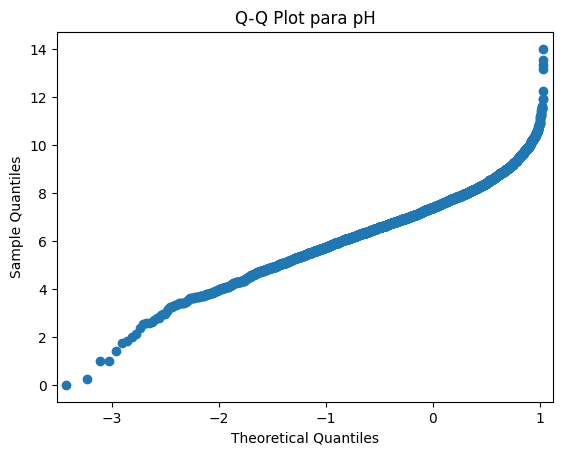

<Figure size 800x400 with 0 Axes>

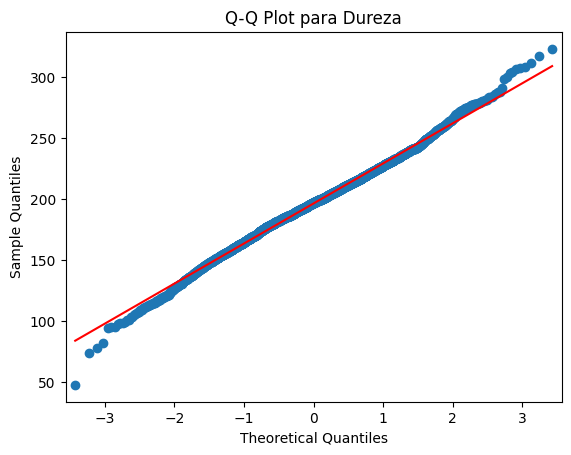

<Figure size 800x400 with 0 Axes>

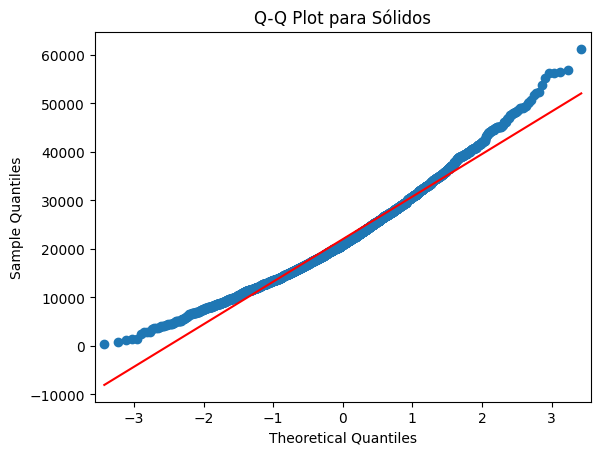

<Figure size 800x400 with 0 Axes>

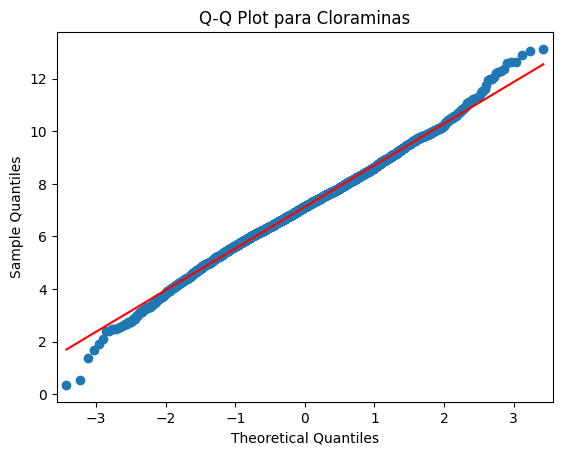

<Figure size 800x400 with 0 Axes>

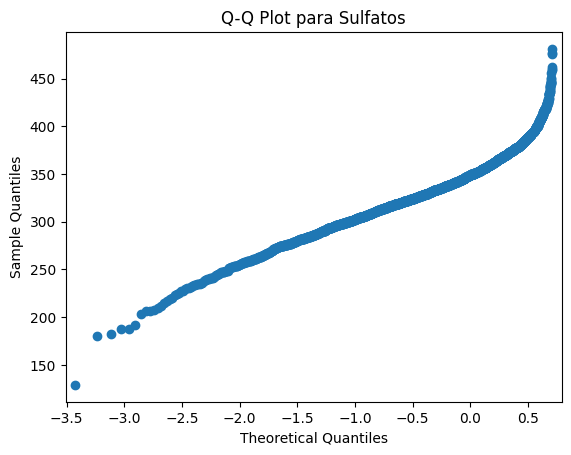

<Figure size 800x400 with 0 Axes>

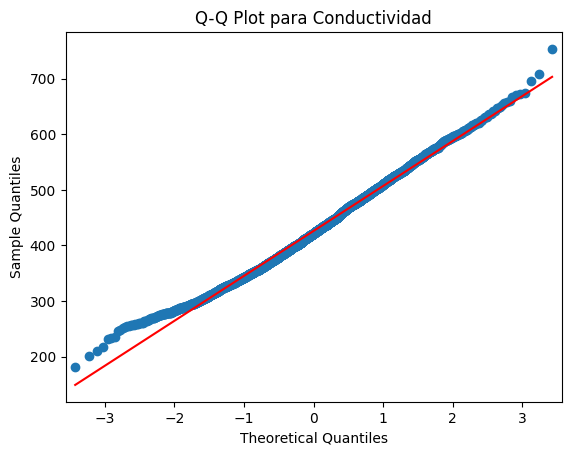

<Figure size 800x400 with 0 Axes>

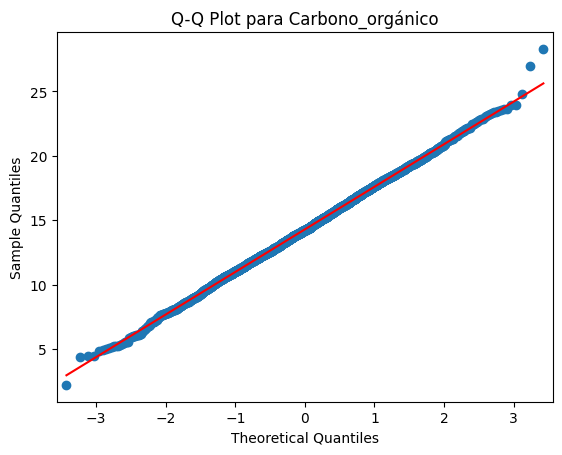

<Figure size 800x400 with 0 Axes>

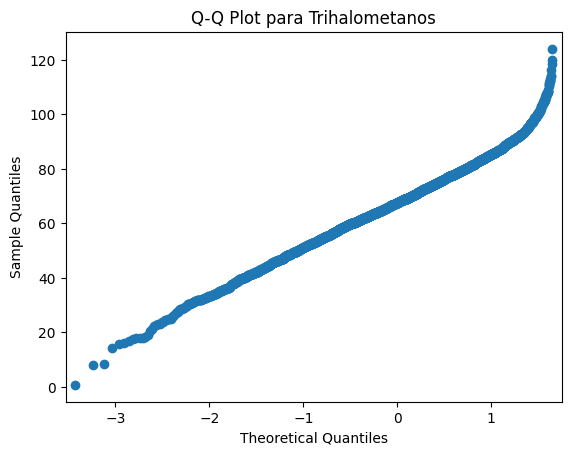

<Figure size 800x400 with 0 Axes>

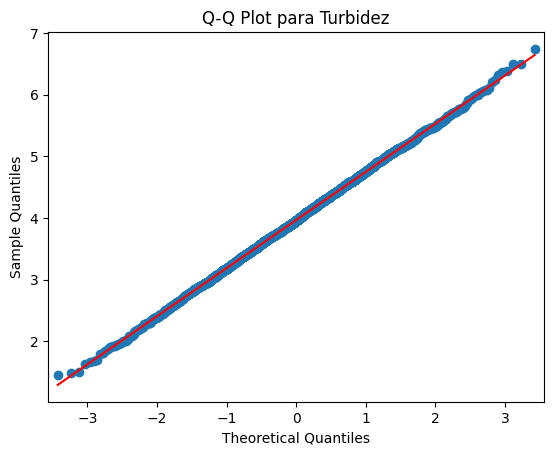

In [4]:
for column in df.loc[:,df.columns !="Potabilidad"]:
    plt.figure(figsize=(8, 4))
    sm.qqplot(df[column], line='s')
    plt.title(f'Q-Q Plot para {column}')
    plt.show()

#### 1.2.1 Conclusiones de la exploración del conjunto de datos.
* El numero de celdas faltantes son 1434, lo cual representa el 4.4% del total de los datos. Esto porcentaje es bajo asi que el dataset se puede usar para el desarrollo del modelo.
* No existen valores duplicados. No es necesario realizar limpieza de estos.
* Se tienen 10 variables en total, 9 numericas (variables independientes) y 1 categorica (variable dependiente).
* De las 10 variables 3 tienen valores faltantes; pH, Sulfatos y Trihalometanos, y el porcentaje de valores faltantes para cada una es; 15%, 23.8% y 4.9% respectivamente.
* Las 3 columnas que tienen valores faltantes presentan una distribución no normal mientras que el resto de columnas su distribución es normal. Como se puede visualizar en las graficas Q-Q.
* Aunque estas propiedades fisicoquimicas son importantes para determinar si el agua es potable o no (según el conocimiento del dominio), existen variables que no tienen ninguna relación con la variable dependiente "Potabilidad", como es el caso de las variables independientes "Conductividad", "Trihalometanos" y "Turbidez".


## 2. Limpieza y preparación de datos
Basados en las conclusiones obtenidas despues de realizar la exploración del conjunto de datos se procede a realizar los siguientes procedimientos para limpiar y preparar los datos para el modelo:

**Antes de realizar la limpieza es importante definir la variable `data` para almacenar un conjunto de datos modificado, utilizando el método `copy()`:**

In [5]:
data = df.copy()

### 2.1 Eliminación de variables poco relevantes
A partir de la conclusión obtenida al revisar el **Informe de Perfil de Datos** se logro determinar que las variables "Conductividad", "Trihalometanos" y "Turbidez" no tienen ninguna relación con la variable objetivo "Potabilidad", asi que se prcede a eliminarlas con la función `drop()`.

In [6]:
data = data.drop(['Conductividad','Trihalometanos','Turbidez'], axis=1)

data.head()

pH  Dureza   Sólidos  Cloraminas  Sulfatos  Carbono_orgánico Potabilidad
0   NaN  204.89  20791.32        7.30    368.52             10.38          NO
1  3.72  129.42  18630.06        6.64       NaN             15.18          NO
2  8.10  224.24  19909.54        9.28       NaN             16.87          NO
3  8.32  214.37  22018.42        8.06    356.89             18.44          NO
4  9.09  181.10  17978.99        6.55    310.14             11.56          NO

### 2.2 División train-test del conjunto de datos despues de reducir la dimensionalidad (Eliminar variables poco relevantes)
Se recomienda hacer esta división antes de hacer la imputación en las columnas con valores faltantes, Esto evita posibles fugas de datos y garantiza una evaluación imparcial del rendimiento del modelo.

**Antes de hacer la división train-test se debe hacer el encoding de la variable categorica "Potabilidad", el cual se hara con un label encoder ya que esta variable es binaria (solo tiene 2 valores: SI y NO), y tambien se debe definir las variables independientes y la variable objetivo**

In [7]:
label_encoder = LabelEncoder()
data['Potabilidad'] = label_encoder.fit_transform(data['Potabilidad'])

In [8]:
X = data.drop(['Potabilidad'],axis=1)
y = data['Potabilidad']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

### 2.3 Imputación de valores faltantes
Se procede a realizar la imputación en las columnas "pH" y "Sulfatos" ya que son las unicas que tienen valores faltantes. El metodo de imputación seleccionado es la media ya que estas dos variables no tienen una distribución normal como las otras, y lo que se busca con esto es que el modelo realice mejor la tarea de clasificación.

In [10]:
# Crear un imputador para llenar los valores faltantes con la media de cada columna
imputer = SimpleImputer(strategy='mean')

# Ajustar y transformar el conjunto de entrenamiento
X_train_imputed = imputer.fit_transform(X_train)

# Transformar el conjunto de prueba con el mismo imputador
X_test_imputed = imputer.transform(X_test)

### 2.4 Eliminación de valores vacios del dataframe
Como los modelos que se van a trabajar suelen funcionar mejor con pocos datos y no es de gran relevancia que haya presencia de valores vacios en el dataframe, se propone evaluar los modelos con el conjunto de datos imputados (paso 2.3) y sin imputar, pero si eliminando los valores vacios.

In [11]:
# Eliminar filas con valores faltantes en el conjunto de entrenamiento
X_train_no_imputation = X_train.dropna()
y_train_no_imputation = y_train[X_train.index]

# Eliminar filas con valores faltantes en el conjunto de prueba
X_test_no_imputation = X_test.dropna()
y_test_no_imputation = y_test[X_test.index]

In [12]:
print(len(X_train_no_imputation), len(y_train_no_imputation))

1705 2620


## 3. Construcción de un modelo de arboles de decisión
Despues de limpiar y preparar los datos se procede a contruir el modelo teniendo en cuenta los datos imputados y sin imputar (dataframe despues de eliminar valores vacios=.

### 3.1 Crear el calsificador del arbol de decisión
Para esto se crea un objeto a partir de la clase `DecisionTreeClassifier()`

In [13]:
decision_tree_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=77)

### 3.2 Definimos el espacio de busqueda de los hiperparametros
creamos una variable que nos almacene un diccionario en donde esten como parametros los pares que definen nuestro espacio de busqueda.

In [14]:
param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [3, 4, 5]
}

### 3.3 Validación cruzada (Cross Validation)
Se define un objeto de la clase `KFold()` para realizar la validación cruzada, especificando 10 subconjuntos con el parámetro n_splits y reordenando el conjunto de datos en cada iteración con el parámetro `shuffle`

In [15]:
kfold = KFold(n_splits=10, shuffle=True, random_state=77)

### 3.4 Definición de la búsqueda con un objeto de la clase `GridSearchCV()`

In [16]:
grid_search_decision_tree = GridSearchCV(decision_tree_classifier, param_grid_decision_tree, cv=kfold, n_jobs=-1)

Se ejecuta la busqueda sobre el conjunto de entrenamiento definido por las variables `X_train_imputed` y `y_train`

In [17]:
grid_search_decision_tree.fit(X_train_imputed, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=77, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=77),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 12],
                         'min_samples_split': [3, 4, 5]})

Ahora se obtienen los mejores valores de los hiperparámetros usando `grid.best_params_`:

In [18]:
print("Mejores parámetros: {}".format(grid_search_decision_tree.best_params_))

Mejores parámetros: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 5}


Como se puede observar, el mejor modelo utiliza el indice gini como criterio de pureza, una profundidad máxima de 6 y un mínimo de 5 datos para realizar una división. Se almacena el mejor modelo utilizando `grid.best_estimator_`:

In [19]:
best_decision_tree_model = grid_search_decision_tree.best_estimator_

Se puede utilizar el atributo `feature_importances_` para obtener un arreglo con los pesos asignados a cada variable. Entre más grande sea el peso, más importante es la variable asociada:

In [20]:
importancia = best_decision_tree_model.feature_importances_
importancia

array([0.3722243 , 0.16108762, 0.05905868, 0.1407741 , 0.23443059,
       0.03242471])

Utilizando los nombres de las variables almacenados en `X_train.columns`, se puede ver más claramente qué peso corresponde a qué variable. Primero crearemos un DataFrame con los valores almacenados en la variable `importancia` y, posteriormente, lo ordenaremos:

In [21]:
importancia_df = pd.DataFrame(data={'Variable':X_train.columns, 'Importancia':importancia})
importancia_df.sort_values('Importancia', ascending=False)

Variable  Importancia
0                pH     0.372224
4          Sulfatos     0.234431
1            Dureza     0.161088
3        Cloraminas     0.140774
2           Sólidos     0.059059
5  Carbono_orgánico     0.032425

Ahora utilizaremos `plot_tree` para visualizar el árbol que almacenamos en la variable `best_decision_tree_model`. Especificaremos el nombre de las variables con el parámetro `feature_names`, el nombre de las clases (en orden ascendente, es decir, primero la clase 0 y luego la clase 1) con el parámetro `class_names` y, finalmente, aplicaremos colores a los nodos para indicar cada clase con el parámetro `filled`:

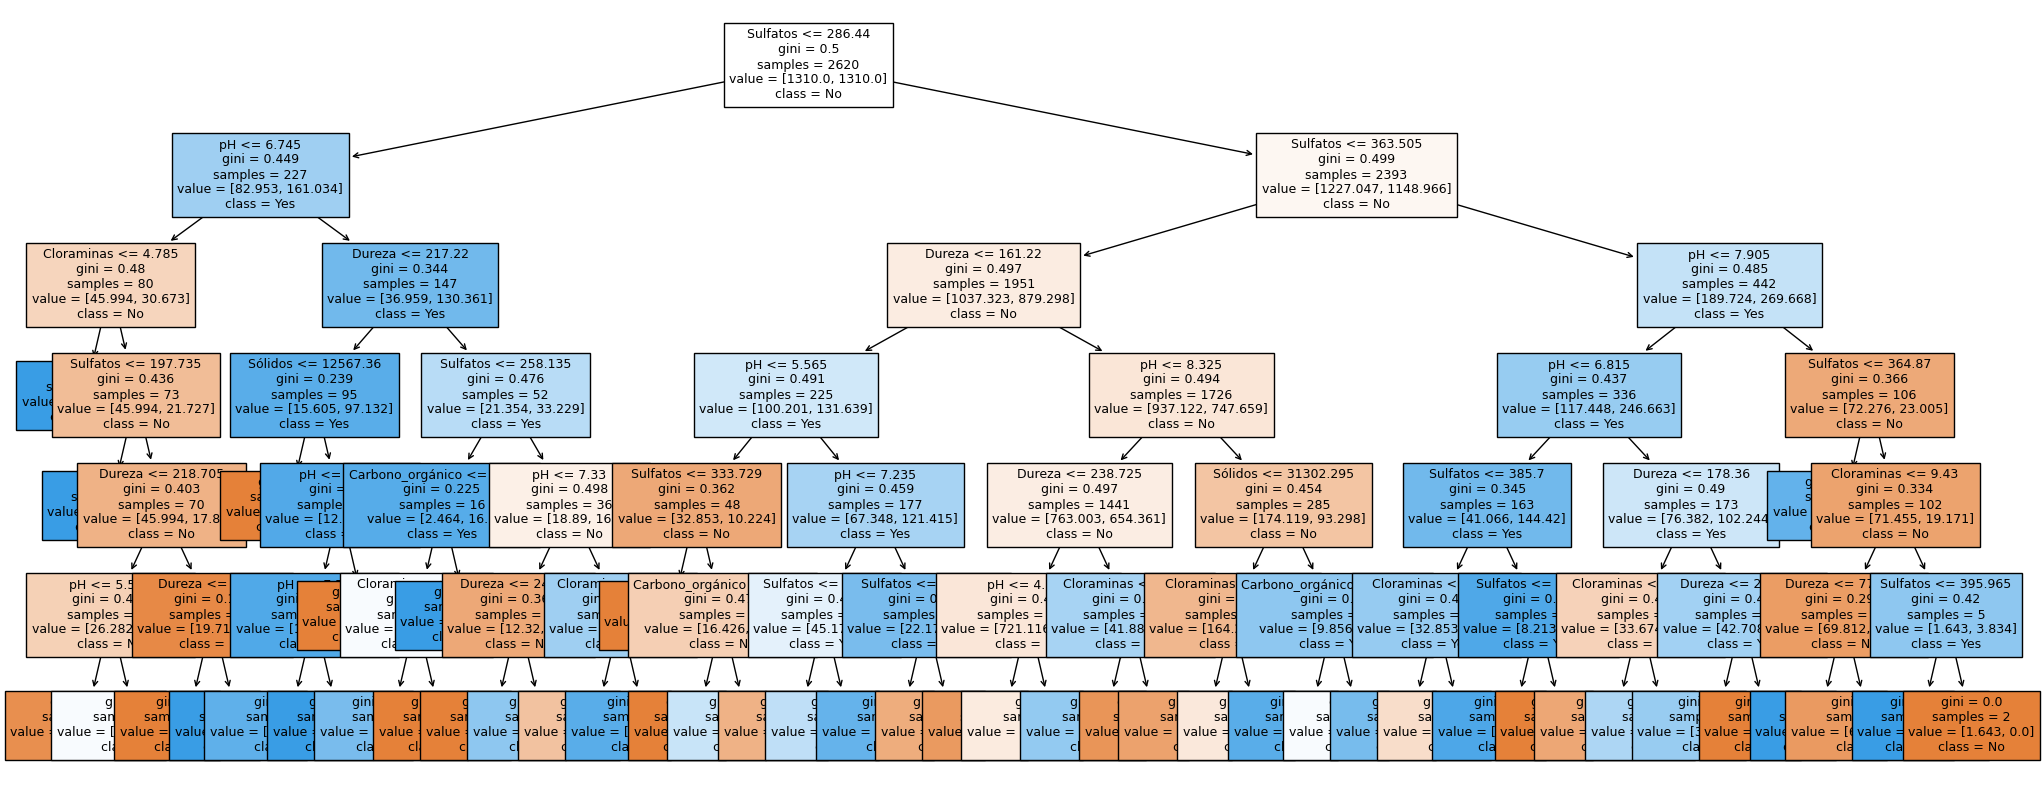

In [22]:
feature_names = list(X_train.columns)

# Visualizar el árbol de decisión
plt.figure(figsize=(25,10))
plot_tree(best_decision_tree_model, feature_names=feature_names, class_names=['No','Yes'], filled=True, fontsize=9)
plt.show()

## 4. Construcción de un modelo k-vecinos

Inicialmente se debe definir los posibles valores de k

In [23]:
k_values = [1, 2, 3, 4, 5]

Se inicializa las variables `best_knn_model` y `best_knn_score` para almacenar el mejor modelo y su puntuación


In [24]:
best_knn_model = None
best_knn_score = 0

Se realiza la búsqueda del mejor valor de K por medio del ciclo for 

In [25]:
for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, X_train_imputed, y_train, cv=5, scoring='f1')
    mean_score = scores.mean()
    if mean_score > best_knn_score:
        best_knn_score = mean_score
        best_knn_model = knn_classifier

Se entrena el mejor modelo de K-Vecinos en el conjunto de datos completo

In [26]:
best_knn_model.fit(X_train_imputed, y_train)

KNeighborsClassifier(n_neighbors=1)

## 5. Evaluación de modelos

Se crea una función que permita evaluar los modelos para cada una de las metricas.

In [27]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, recall, precision, f1

Se definen las variables para evaluar el modelo de arboles de decisión con imputación

In [28]:
accuracy_dt_imputed, recall_dt_imputed, precision_dt_imputed, f1_dt_imputed = evaluate_model(best_decision_tree_model, X_train_imputed, y_train, X_test_imputed, y_test)

Se definen las variables para evaluar el modelo de ñ-vecinos con imputación

In [29]:
accuracy_knn_imputed, recall_knn_imputed, precision_knn_imputed, f1_knn_imputed = evaluate_model(best_knn_model, X_train_imputed, y_train, X_test_imputed, y_test)

Se crea y muestra la tabla comparativa con los valores de cada metrica para los modelos evaluados.

In [30]:
comparison_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Recall', 'Precision', 'F1-Score'],
    'Decision Tree (Imputed)': [accuracy_dt_imputed, recall_dt_imputed, precision_dt_imputed, f1_dt_imputed],
    'K-Nearest Neighbors (Imputed)': [accuracy_knn_imputed, recall_knn_imputed, precision_knn_imputed, f1_knn_imputed]
})

print(comparison_table)

      Metric  Decision Tree (Imputed)  K-Nearest Neighbors (Imputed)
0   Accuracy                 0.655488                       0.530488
1     Recall                 0.387352                       0.371542
2  Precision                 0.579882                       0.386831
3   F1-Score                 0.464455                       0.379032


## 6. Generación de reglas apartir del arbol de decisión

1. Si la concentración de sulfatos es **menor o igual** a 286.44 mg/L el agua no es potable.
2. Si el pH es menor o igual a 6.745 el agua es potable.
3. Si la concentración de cloraminas es **menor o igual** a 4.785 mg/L el agua no es potable.
4. Si la dureza wa menor o igual a 217.22  pero mayor que 161.22 el agua es potable.


## 7. Analisis de resultados

1. **¿Qué puedes decir de los valores de las métricas recall y precisión para cada una de las clases en cada modelo?**
La metrica recall para ambos modelos es muy similar y es muy baja, lo que quiere decir que la capacidad para encontrar todos los casos positivos en el conjunto de datos es muy baja. Con respecto a la metrica precisión se puede evidenciar que es mucho mas alta en el modelo de arboles de decisión, lo que puede indicar que la imputación por la media no es una tecnica adecauda para remplazar los valores vacios y esto afecta la tarea de clasificación para el modelo de k-vecinos.
2. **¿Cuál de estás métricas consideras que es más importante con base en la descripción del problema?**
La metrica mas importante es la precisión, porque lo que se busca es que tenga la mayor precision para que no vaya a generar problemas de salud en una población por estar clasificando las clases de manera incorrecta.
3. **¿Consideras que el rendimiento de los modelos es adecuado? Si no es así, ¿cómo podrían mejorarse los resultados?**
Personalmente pienso que no es el mejor. Se deberian tener un poco mas de conocimiento de los datos, como por ejemplo; escala de las variables, mayor dominio del conocimiento y conocer las zonas donde se realizo el estudio. Esto puede permitir una mejor toma de decisiones a la hora de preparar y limpiar los datos.
4. **¿Cuáles son las variables más significativas según el mejor modelo basado en árboles de decisión? Reflexiona sobre cómo este nuevo conocimiento podría ayudar a tomar decisiones en el contexto del problema.**
La variable mas significativa es **Sulfatos**, pero por debajo de ella tambien se encuentra el **pH**, **la dureza** y en menor proporción la concentración de **Cloraminas**. Este conocimiento puede ayudar a mejorar la forma en que se estan tomando y tratando los datos.
5. **Si los dos modelos proporcionan resultados similares en cuanto a las métricas de rendimiento ¿Cuál seleccionarías tomando en cuenta el contexto del problema?**
Creo que tomaria en consideración el modelo de arboles de decisión ya que considero que es el mas adecuado para este tipo de aplicaciones, porque permite generar una serie de reglas a partir de los diferentes valores para cada variable o caracterisitica.

**Elaborado por:** Danilo Alfonso Duarte Yancy